In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams.update({"font.size":12})

from EEM import RE_A,ABS,RMSE,_preprocess_data


Faire une PCA sur une variable de progres entre 0.9 et 1 (fuel ou temperature) 

In [2]:


# Paramètres
detailed = pd.read_csv("Processing_Detailed.csv")
list_species = ["Y_H2O","Y_NH3","Y_OH","Y_HNO"]  # mettre tes espèces

# list_species = [col for col in detailed.columns if col.startswith("Y_") ]


X = 50
T = 1000
Phi = 0.8
epsilon = 5e-4

df_subset = detailed.loc[
    (detailed["T_Init"] == T) & (detailed["Phi_Init"] == Phi),
    list_species+["common_grid","T_Init","Phi_Init"]
].iloc[X:]
time = df_subset["common_grid"].values

# Nouvelle grille temporelle
time_forward = time + epsilon
time_backward = time - epsilon

# Initialisation des DataFrames
df_forward = pd.DataFrame({"common_grid": time_forward})

dt = time[1] - time[0]  # résolution temporelle
shift_idx = int(round(epsilon / dt))

df_forward = df_subset.copy()


# Décaler les valeurs par indices
for sp in list_species:
    df_forward[sp].iloc[:-shift_idx] = df_subset[sp].iloc[shift_idx:].values
    df_forward[sp].iloc[-shift_idx:] = df_subset[sp].iloc[-1]  # ou np.nan


# Ajouter les colonnes de condition
df_forward["T_Init"] = T
df_forward["Phi_Init"] = Phi
df_forward["common_grid"] =time

/tmp/ipykernel_29058/3487579731.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_forward[sp].iloc[:-shift_idx] = df_subset[sp].iloc[shift_idx:].values
/tmp/ipykernel_29058/3487579731.py:34: SettingWithCopyWarning: 
A value is trying t

In [5]:

# listes des métriques et des directions
metrics = ["ABS", "RMSE", "RE_A"]
directions = {"fwd": df_forward}

# 1️⃣ Sans log ni normalisation
all_errors = {}
for m in metrics:
    for dname, ddata in directions.items():
        key = f"{m}_{dname}"
        all_errors[key] = globals()[f"{m}"](df_subset, ddata, list_species, flag_output=True)


# 2️⃣ Avec log
all_errors_log = {}
for m in metrics:
    for dname, ddata in directions.items():
        key = f"{m}_{dname}"
        all_errors_log[key] = globals()[f"{m}"](df_subset, ddata, list_species, flag_output=True, do_log=True)

# 3️⃣ Normalisation Standard
all_error_norm_S = {}
for m in metrics:
    for dname, ddata in directions.items():
        key = f"{m}_{dname}"
        all_error_norm_S[key] = globals()[f"{m}"](df_subset, ddata, list_species, flag_output=True, norm_type="standard")

# 4️⃣ Log + Normalisation Standard
all_error_log_norm_S = {}
for m in metrics:
    for dname, ddata in directions.items():
        key = f"{m}_{dname}"
        all_error_log_norm_S[key] = globals()[f"{m}"](df_subset, ddata, list_species, flag_output=True, do_log=True, norm_type="standard")

# 3️⃣ Normalisation Standard
all_error_norm_M = {}
for m in metrics:
    for dname, ddata in directions.items():
        key = f"{m}_{dname}"
        all_error_norm_M[key] = globals()[f"{m}"](df_subset, ddata, list_species, flag_output=True, norm_type="minmax")

# 4️⃣ Log + Normalisation Standard
all_error_log_norm_M = {}
for m in metrics:
    for dname, ddata in directions.items():
        key = f"{m}_{dname}"
        all_error_log_norm_M[key] = globals()[f"{m}"](df_subset, ddata, list_species, flag_output=True, do_log=True, norm_type="minmax")

dicts_ratio = [all_errors, all_errors_log, all_error_norm_S, all_error_log_norm_S,all_error_norm_M,all_error_log_norm_M]


In [6]:
all_errors_log

{'ABS_fwd': Species  Phi_Init  T_Init      Y_H2O      Y_HNO       Y_NH3       Y_OH
 0             0.8    1000  44.021799  81.414516  140.256873  90.956977,
 'RMSE_fwd': Species  Phi_Init  T_Init     Y_H2O     Y_HNO     Y_NH3      Y_OH
 0             0.8    1000  0.097031  0.503774  1.480141  0.489879,
 'RE_A_fwd': Species  Phi_Init  T_Init     Y_H2O     Y_HNO     Y_NH3      Y_OH
 0             0.8    1000  0.014577  0.000879  0.013112  0.009513}

In [7]:
error_types = [ "ABS", "RMSE", "RE_A"]
transfo_labels = ["Raw", "Log", "Std", "Log+Std","Mm","Log+Mm"]
list_species = ["Y_H2O","Y_NH3","Y_OH","Y_HNO"]

notation1=[r"$Y_{H_2O}$",r"$Y_{NH_3}$",r"$Y_{OH}$",r"$Y_{HNO}$"]
notation=[r"$Y_{NH_3}$",r"$Y_{OH}$",r"$Y_{HNO}$"]

def build_matrix(direction):
    """Construit un dict {error_type: DataFrame} pour fwd ou bwd"""
    matrices = {}
    for err in error_types:
        matrix = np.zeros((len(list_species), len(transfo_labels)))
        for i, sp in enumerate(list_species):
            for j, d in enumerate(dicts_ratio):  # transformations
                val = d[f"{err}_{direction}"].set_index(["T_Init","Phi_Init"])[sp].values[0]
                matrix[i, j] = val
        df = pd.DataFrame(matrix, index=notation1, columns=transfo_labels)
        matrices[err] = df
    return matrices



def build_matrix2(direction, species_ref="Y_H2O"):
    """Construit un dict {error_type: DataFrame} normalisé par l'espèce species_ref"""
    matrices = {}
    
    # liste des espèces sans référence
    species_others = [s for s in list_species if s != species_ref]
    # species_others = list_species
    for err in error_types:
        matrix = np.zeros((len(species_others), len(transfo_labels)))
        for j, d in enumerate(dicts_ratio):
            # valeur de référence
            ref = d[f"{err}_{direction}"].set_index(["T_Init","Phi_Init"])[species_ref].values[0]
            for i, sp in enumerate(species_others):
                val = d[f"{err}_{direction}"].set_index(["T_Init","Phi_Init"])[sp].values[0]
                matrix[i, j] = val / ref if ref != 0 else np.nan

        # creation DataFrame
        df = pd.DataFrame(matrix,
                          index=notation,
                          columns=transfo_labels)
        matrices[err] = df

    return matrices





                 Raw         Log         Std    Log+Std        Mm    Log+Mm
$Y_{H_2O}$  1.438779  146.331203   17.192737  53.873048  8.008419  5.646731
$Y_{NH_3}$  0.841388  140.274508   16.738934  16.387273  7.999999  8.079201
$Y_{OH}$    0.070655  163.340611   21.904147  30.988721  8.365824  7.146222
$Y_{HNO}$   0.001311  189.751632  140.706772  97.388287  6.070968  9.887719

/tmp/ipykernel_29058/1168412130.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.9,1])


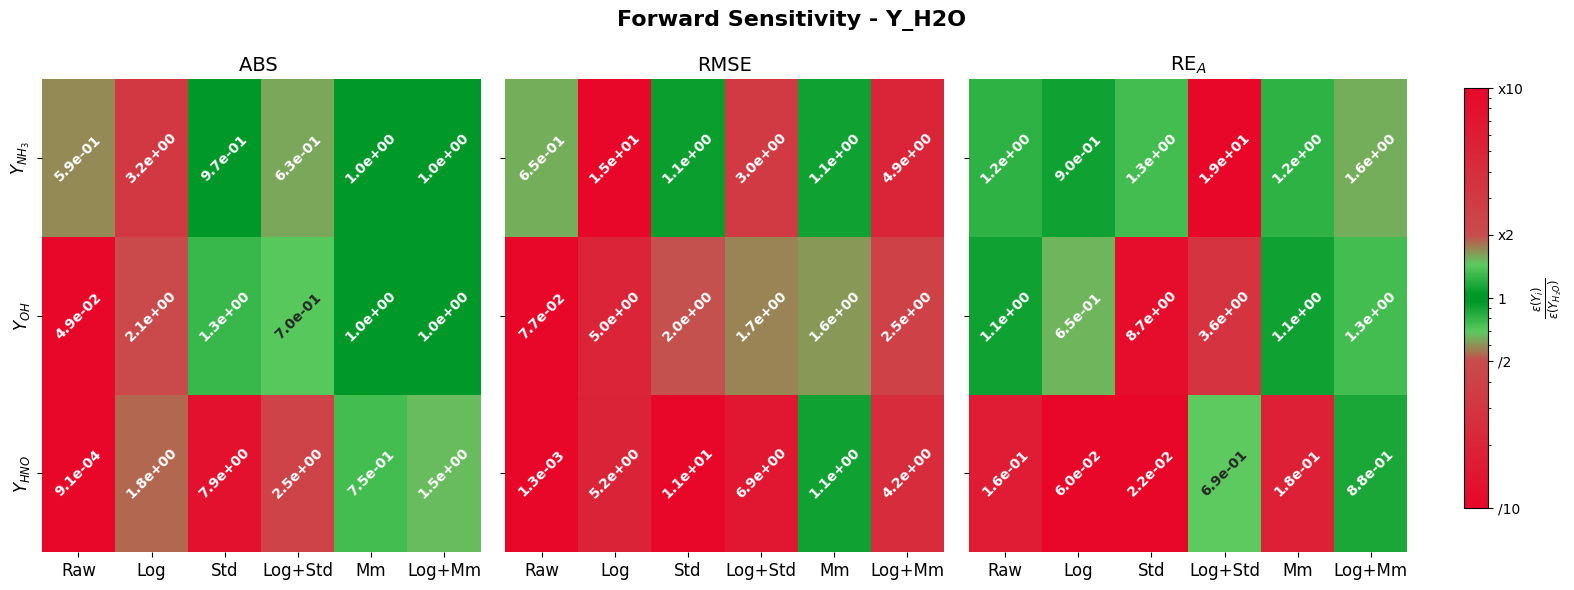

In [9]:

# Exemple : matrice
fwd_matrices = build_matrix2("fwd","Y_H2O")

fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16,6))

# Paramètres de l'échelle
vmin = 0.1
vmax = 10
center = 1

# Couleurs personnalisées : rouge foncé → vert clair → rouge foncé
colors = [
    (0.0, "#e80729"),   # rouge foncé début
    (0.35, "#C94C4C"),   # rouge intermédiaire
    (0.42, "#5ccb5f"),  # début vert clair
    (0.49,"#009929"), 
    (0.51,"#009929"),
    (0.58, "#5ccb5f"),  # fin vert
    (0.65, "#C94C4C"),   # rouge intermédiaire après vert
    (1.0, "#e80729")    # rouge foncé fin
]
cmap = LinearSegmentedColormap.from_list("CustomRedGreenRed", colors)

# Norme logarithmique pour symétrie autour de 1
norm = LogNorm(vmin=vmin, vmax=vmax)

# Heatmaps
hm0 = sns.heatmap(fwd_matrices["ABS"], ax=axes[0], annot=True, fmt=".1e",
                  annot_kws={"size": 10, "rotation": 45, "fontweight": "bold"},
                  cbar=False, cmap=cmap, norm=norm)
hm1 = sns.heatmap(fwd_matrices["RMSE"], ax=axes[1], annot=True, fmt=".1e",
                  annot_kws={"size": 10, "rotation": 45, "fontweight": "bold"},
                  cbar=False, cmap=cmap, norm=norm)
hm2 = sns.heatmap(fwd_matrices["RE_A"], ax=axes[2], annot=True, fmt=".1e",
                  annot_kws={"size": 10, "rotation": 45, "fontweight": "bold"},
                  cbar=False, cmap=cmap, norm=norm)

# Colorbar dédiée
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(hm2.collections[0], cax=cbar_ax, ticks=[0.1,0.5,1,2,10])
cbar.ax.set_yticklabels(["/10","/2","1","x2","x10"], fontsize=10)
cbar.set_label(r"$\frac{\epsilon(Y_i)}{\epsilon(Y_{H_2O})}$")


# Titres
axes[0].set_title("ABS ", fontsize=14)
axes[1].set_title("RMSE", fontsize=14)
axes[2].set_title(r"RE$_A$", fontsize=14)
fig.suptitle("Forward Sensitivity - Y_H2O", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0,0,0.9,1])

plt.savefig(f"FWD_sensitivity_H2O_Eps_{epsilon}.png")
plt.show()



In [14]:
toto = build_matrix("fwd")
print(toto["RE_A"])

                 Raw       Log          Std     Log+Std        Mm    Log+Mm
$Y_{H_2O}$  0.015038  0.014577   141.274630   32.266832  0.015135  0.011071
$Y_{NH_3}$  0.018447  0.013112   185.569918  613.831998  0.018447  0.017311
$Y_{OH}$    0.016644  0.009513  1235.493419  115.684034  0.016644  0.014759
$Y_{HNO}$   0.002474  0.000879     3.075334   22.208795  0.002710  0.009754


(0.025, 0.035)

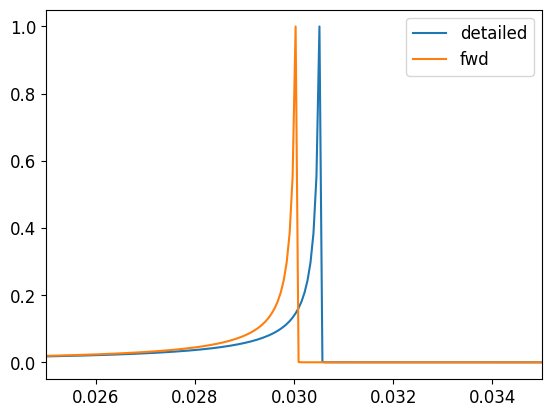

In [24]:
df_subset_change,df_forward_change = _preprocess_data(df_subset,df_forward,list_species,False,"minmax")

plt.figure()
plt.plot(time,df_subset_change["Y_HNO"],label="detailed")
plt.plot(time,df_forward_change["Y_HNO"],label="fwd")
plt.legend()
plt.xlim([0.025,0.035])

In [25]:
for sp in list_species : 
    A_d = np.trapezoid(df_subset_change[sp],time)
    A_f = np.trapezoid(df_forward_change[sp],time)
    
    print(f"{sp} : A_d = {A_d:.2e}, A_f = {A_f:.2e}")
    print(f"RE_A = {np.abs(A_d - A_f)/A_d}")

Y_H2O : A_d = 3.17e-02, A_f = 3.22e-02
RE_A = 0.015135176846827978
Y_NH3 : A_d = 2.60e-02, A_f = 2.56e-02
RE_A = 0.018447134615940372
Y_OH : A_d = 2.25e-02, A_f = 2.29e-02
RE_A = 0.0166440680670624
Y_HNO : A_d = 5.63e-04, A_f = 5.61e-04
RE_A = 0.002709604279841463
